In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader, random_split

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor


from mmd import _mix_rq_kernel, _mix_rbf_kernel, _distance_kernel, mmd2, gradient_penalty
from architecture import Generator_MNIST, Discriminator_MNIST
from utils import show, weights_init
print(device)

cuda


## Without Discriminator

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = FashionMNIST(os.getcwd(), train=True, transform=transform, download=False)

samples_per_class = {i: [] for i in range(10)}  

for data, target in train_set:
    if len(samples_per_class[target]) < 600:
        samples_per_class[target].append(data.view(-1))
    if all(len(samples) == 600 for samples in samples_per_class.values()):
        break

# Combine all the collected samples into a single tensor
y = torch.cat([torch.stack(samples_per_class[i]) for i in range(10)]).to(device)
print(y.shape)


batch_size = 500
dataset = TensorDataset(y)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

torch.Size([6000, 784])


/users/eleves-a/2021/ahmad.rammal/miniconda3/envs/gm/lib/python3.9/site-packages/torch/nn/modules/conv.py:952: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv_transpose2d(


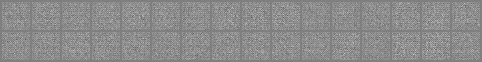

In [4]:
# Create the generator and discriminator

nz = 100 # Input noise dimension
G = Generator_MNIST(nz=nz).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);

show(G);

In [5]:
lr = 0.001   # learning rate for generator
kernel = _distance_kernel
n_epochs = 50
b=batch_size

torch.manual_seed(1)  # initialize random seed for reproducibility

optimG = optim.Adam(G.parameters(), lr=lr)

Glosses = []

iter_display = 5
loss_display = 10

[0/50] 	Loss_G: 4.2719


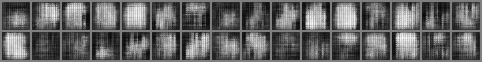

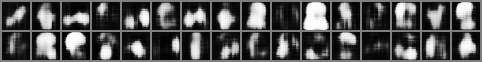

[10/50] 	Loss_G: 0.1105


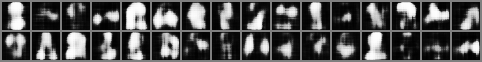

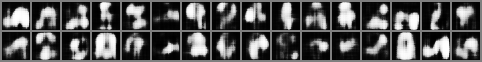

[20/50] 	Loss_G: 0.0985


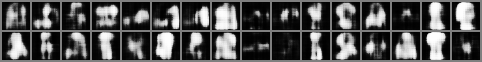

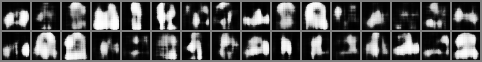

[30/50] 	Loss_G: 0.0587


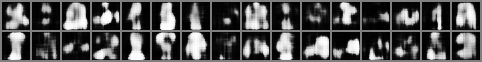

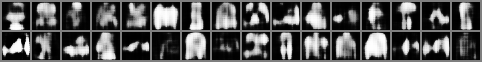

[40/50] 	Loss_G: 0.0565


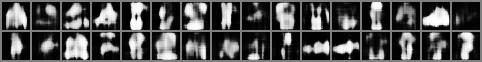

In [ ]:
# Main loop
for epoch in range(n_epochs):

    for y in data_loader:
        Gloss = torch.tensor(0.0, device=device)
        z = torch.randn(b,nz,1,1).to(device)
        x = G(z).reshape(b, 28*28)
        optimG.zero_grad()
        Gloss = mmd2(kernel, x, y[0].reshape(b, 28*28))
        Gloss.backward()
        optimG.step()

    # Output training stats
    if (epoch % loss_display == 0):
        print('[%d/%d] \tLoss_G: %.4f'
          % (epoch, n_epochs, Gloss.item()))
        Glosses.append(Gloss.item())


    if(epoch % iter_display == 0):
        show(G)

In [ ]:
show(G, batch_size=128)

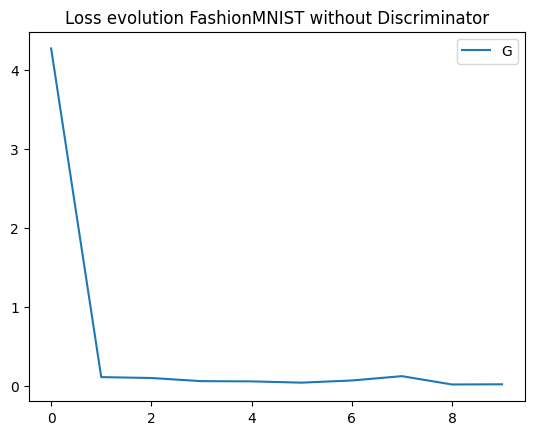

In [21]:
plt.figure(dpi=100)
plt.plot(Glosses,label='G')
plt.title('Loss evolution FashionMNIST without Discriminator')
plt.legend()
plt.show()

## With Discriminator

In [34]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = FashionMNIST(os.getcwd(), train=True, transform=transform, download=False)

samples_per_class = {i: [] for i in range(10)}  

for data, target in train_set:
    if len(samples_per_class[target]) < 600:
        samples_per_class[target].append(data.view(-1))
    if all(len(samples) == 600 for samples in samples_per_class.values()):
        break

# Combine all the collected samples into a single tensor
y = torch.cat([torch.stack(samples_per_class[i]) for i in range(10)]).to(device)


batch_size = 500

dataset = TensorDataset(y.reshape(-1, 1, 28, 28))

split_sizes = [len(dataset) // 2, len(dataset) - (len(dataset) // 2)]

# Randomly split the dataset into two parts
train_dataset, test_dataset = random_split(dataset, split_sizes)

# Create data loaders for each split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

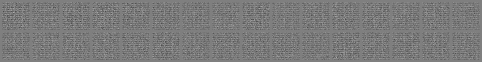

In [35]:
# Create the generator and discriminator

nz = 100 # Input noise dimension
G = Generator_MNIST(nz=nz).to(device)
G.apply(weights_init);
D = Discriminator_MNIST().to(device)
D.apply(weights_init)

show(G)

In [36]:
lr = 0.005
kernel = _distance_kernel

## parameters for training
n_epochs = 500
niterD= 5
niterG= 2
b = batch_size
gpw = 1

torch.manual_seed(1) 

optimD = optim.Adam(D.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=5e-1)
optimG = optim.Adam(G.parameters(), lr=1e-4, betas=(0.9, 0.999))

# optimG = optim.Adam(G.parameters(), lr=0.01)
# optimD = optim.Adam(D.parameters(), lr=lr)

Glosses = []
Dlosses = []

iter_display = 2000
loss_display = 10

[0/500] 	Loss_D: 1.2184	Loss_G: 1.5422


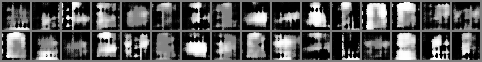

[10/500] 	Loss_D: 2.9143	Loss_G: 1.4065


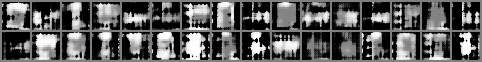

[20/500] 	Loss_D: 1.2216	Loss_G: 1.4249


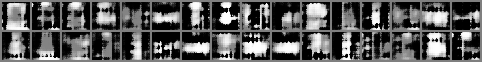

[30/500] 	Loss_D: 2.2779	Loss_G: 2.4274


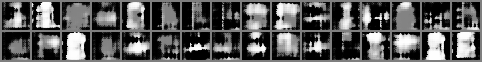

[40/500] 	Loss_D: 9.6622	Loss_G: 9.1171


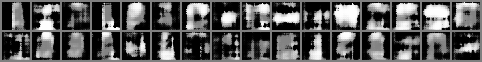

[50/500] 	Loss_D: 24.6493	Loss_G: 20.6178


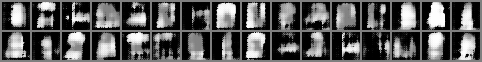

[60/500] 	Loss_D: 28.1435	Loss_G: 1.8640


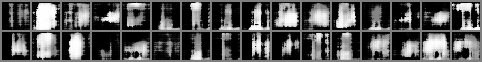

[70/500] 	Loss_D: 16.4750	Loss_G: 8.0960


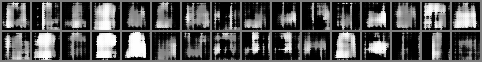

[80/500] 	Loss_D: 0.3023	Loss_G: 0.9340


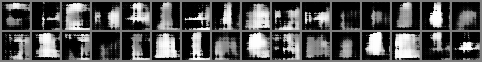

[90/500] 	Loss_D: 2.8731	Loss_G: 4.1068


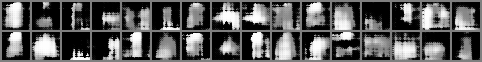

In [45]:
# Main loop
torch.manual_seed(1) 

for epoch in range(100):
    
        ############################
        ### Train discriminator (niterD iterations)
        ############################
            
        Gloss = torch.tensor(0.0, device=device)
        Dloss = torch.tensor(0.0, device=device)
        for iter in range(0, niterD):
            Dloss_cum = 0.0
            for y in train_loader:
                optimD.zero_grad()
                z = torch.randn(b, nz, 1, 1).to(device)
                x = G(z)
                Dloss = -mmd2(kernel, D(x), D(y[0])) + gpw*gradient_penalty(D, kernel, x, y[0])
                Dloss.backward()
                optimD.step()
                Dloss_cum += -Dloss.item()
            Dloss_cum /= len(train_loader)
        
        
        ############################
        ### Train generator (niterG iterations)
        ############################
        for iter in range(0, niterG):
            Gloss_cum = 0.0
            for y in test_loader:
                optimG.zero_grad()
                z = torch.randn(b,nz,1,1).to(device)
                x = G(z)
                Gloss = mmd2(kernel, D(x), D(y[0]))
                Gloss.backward()
                optimG.step()
                Gloss_cum += Gloss.item()
            Gloss_cum /= len(test_loader)
        # print(Gloss_cum)
        # Output training stats
        if (epoch%loss_display ==0):
            print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
            % (epoch, n_epochs, Dloss_cum, Gloss_cum))
            Glosses.append(Gloss_cum)
            Dlosses.append(Dloss_cum)
            show(G);

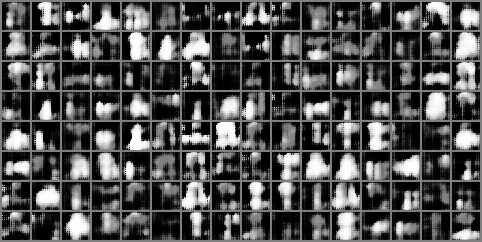

In [41]:
show(G, batch_size = 128)

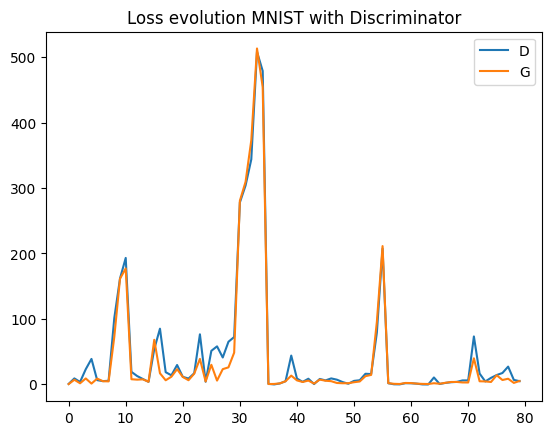

In [44]:
plt.figure(dpi=100)
plt.plot(Dlosses,label='D')
plt.plot(Glosses,label='G')
plt.title('Loss evolution MNIST with Discriminator')
plt.legend()
plt.show()